### Notebook for the complete network, dataset creation, and testing. 

In [34]:
#Import packages
import torchio as tio
from torch.utils.data import dataloader
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm
import numpy as np
import torchtuples as tt
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv
import shap
np.random.seed(1234)
_ = torch.manual_seed(1234)

In [2]:
# Load data into dataframes 

metadata =pd.read_csv("/home/anders/Phd_Interview_project_dataset/metadata.csv")
pat_ct = metadata.loc[(metadata['Modality'] == "CT")]
patients = pat_ct["Subject ID"].to_numpy()
pat_ct.set_index('Subject ID', inplace=True)

data = pd.read_excel("Colorectal-Liver-Metastases-Clinical-data-April-2023.xlsx")
surv_data = data[["Patient-ID", "vital_status", "overall_survival_months"]].copy()
data.drop(columns=["vital_status", "overall_survival_months", "De-identify Scout Name", "months_to_DFS_progression", "vital_status_DFS", "months_to_liver_DFS_progression", "vital_status_liver_DFS", "relevant_notes", "progression_or_recurrence", "progression_or_recurrence_liveronly"], inplace=True)


# Helper functions 

def Get_pat_imgs(df, patientid):
    loc = "/home/anders/Phd_Interview_project_dataset/" + df.loc[patientid]["File Location"][2:] + "/"
    return loc

def get_pat_surv_dat(df, patientid):
    data = torch.asarray(df.loc[df["Patient-ID"] == patientid].iloc[:,1:].values[0])
    return data[0], data[1]

def Get_patient_covariate_data(df, patient_ID):
    return torch.asarray(df.loc[df["Patient-ID"] == patient_ID].iloc[:,1:].values[0]).to(torch.float32)

/home/anders/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
#Partition into train and val set
train_data = data
test_data = data.sample(frac=0.2)
train_data = train_data.drop(test_data.index)

surv_train_targ = surv_data.drop(test_data["Patient-ID"].index)
surv_test_targ = surv_data.drop(train_data["Patient-ID"].index)

#Perform label transform and discretization of the datapoints
labtrans = LogisticHazard.label_transform(20)
target_train = labtrans.fit_transform(surv_train_targ["overall_survival_months"].values, surv_train_targ["vital_status"].values)
target_test = labtrans.fit_transform(surv_test_targ["overall_survival_months"].values, surv_test_targ["vital_status"].values)

In [4]:
#Create a torchio dataset that is also compatible with the Pycox environment
# Dataloader needs to output this:  input, target = data

class FusionSurvDataset():
    def __init__(self, tiodataset, time, event, testmode=False):
        self.tiodataset = tiodataset
        self.time, self.event = tt.tuplefy(time, event).to_tensor()
        self.testmode = testmode
    
    def __len__(self):
        return len(self.time)
    
    def __getitem__(self, indx):
        data = self.tiodataset[indx]
        img = data.image.data
        covariates = data.covariates
        if not self.testmode:
            return tt.tuplefy((img, covariates), (self.time[indx], self.event[indx]))
        else:
            return tt.tuplefy((img, covariates))


In [5]:
target_train

(array([16,  4, 13, 13,  3, 14,  4, 10, 12, 15, 12, 13, 11, 18, 16, 16,  4,
         5, 17, 12,  3,  9, 10,  8, 11, 11, 13,  3, 11,  5, 13, 10,  5,  7,
        13,  3,  5,  1, 13,  3, 10, 14,  2,  7,  6, 15, 15,  4,  6, 13, 12,
         9, 17, 10,  9, 17, 11,  5,  8,  2, 14, 15,  5, 14,  5, 10, 17, 13,
         1,  8, 17,  4, 10, 11, 12, 17,  6, 18, 14,  6,  5,  8,  3,  9,  5,
         5, 10, 18, 15, 11, 16, 13,  4,  5, 14,  8,  5,  6, 13,  7, 13, 14,
        12, 15, 14,  3,  2, 11,  9,  3,  8,  8,  8,  5, 16,  7, 11, 17,  8,
         7,  3,  7,  5,  8,  9, 16,  9,  7,  8, 15, 19, 12, 13,  8,  8, 13,
         2, 10, 10,  3, 14,  9,  6,  4,  5, 17,  9,  3, 17,  4, 15,  6,  2,
        12,  4, 14, 15, 15]),
 array([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.

In [6]:
Transforms = tio.Compose([
    tio.Resample(1),
    tio.ZNormalization(),
    tio.Resize((128,128,240))
])

def Get_Subjects(Idlist):
    Subject_list = []
    for i,subject in enumerate(Idlist):
        dir = Get_pat_imgs(pat_ct, subject)
        covariates = Get_patient_covariate_data(data, subject)
        event, time = get_pat_surv_dat(surv_data, subject)
        subject = tio.Subject(
        image = tio.ScalarImage(dir),
        covariates = covariates,
        )
        Subject_list.append(subject)
    return Subject_list

Train_Subjects = Get_Subjects(surv_train_targ["Patient-ID"].to_list())
Test_Subjects = Get_Subjects(surv_test_targ["Patient-ID"].to_list())

In [7]:
#Load all subjects into ram for faster iterations

def LoadSubjectList(Subjectlist):
    print('Loading data from', Subjectlist,'...')
    for subject in tqdm(Subjectlist):
        subject.load()  # load images, caching the voxel data in RAM

LoadSubjectList(Train_Subjects)
LoadSubjectList(Test_Subjects)

Loading data from [Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys

100%|██████████| 158/158 [00:25<00:00,  6.14it/s]


Loading data from [Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys: ('image', 'covariates'); images: 1), Subject(Keys

100%|██████████| 39/39 [00:08<00:00,  4.67it/s]


In [8]:
#Training split
Train_tio_dataset = tio.SubjectsDataset(Train_Subjects, transform=Transforms)
Train_Fusion_dataset = FusionSurvDataset(Train_tio_dataset, target_train[0], target_train[1])

#Validation / Testing split 
Test_tio_dataset = tio.SubjectsDataset(Test_Subjects, transform=Transforms)
Test_Fusion_dataset = FusionSurvDataset(Test_tio_dataset, target_test[0], target_test[1])

In [9]:
#Need the Pycox-collate 
def collate_fn(batch):
    """Stacks the entries of a nested tuple"""
    return tt.tuplefy(batch).stack()

In [10]:
dl_train = DataLoader(Train_Fusion_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
dl_test = DataLoader(Test_Fusion_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


In [11]:
batch = next(iter(dl_train))
covdata = batch[0][1]
covdata.dtype

torch.float32

In [80]:
#Defining the network
class FusionSurv(nn.Module):
    
    def __init__(self, clinical_inputs=25, ct_cov=12, clin_cov=12, out_haz=32):
        super().__init__()

        self.CT_net = nn.Sequential(
            # 
            nn.Conv3d(1, 2, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm3d(2),
            nn.Dropout(p=0.2),

            nn.Conv3d(2, 4, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm3d(4),
            nn.Dropout(p=0.2),

            nn.Conv3d(4, 8, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm3d(8),
            nn.Dropout(p=0.2),

            nn.Conv3d(8, 1, kernel_size=2, stride=2),
            nn.BatchNorm3d(1), 
            nn.Flatten(start_dim=2),
            nn.Linear(960, ct_cov),
            nn.ReLU(), # some of the outputs are 0, but this should be fine?
            #nn.Sigmoid(), # create logits # I shouldn't need to apply sigmoid yet, and risk saturating the gradients.
        )

        self.Clin_net = nn.Sequential(
            nn.Linear(clinical_inputs, 32),
            nn.ReLU(),
            nn.BatchNorm1d(1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(1),
            nn.Linear(16, clin_cov),
            nn.ReLU(),
        )

        self.Surv_net = nn.Sequential(
            nn.Linear(ct_cov + clin_cov, 64),
            nn.ReLU(),
            nn.BatchNorm1d(1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(1),
            nn.Linear(32, out_haz),
            nn.Sigmoid(), # Sigmoid to create logistic hazard outputs.
        )

    
    def forward(self, *args):
        try:
            im, clin = args[0], args[1]
        except:
            im, clin = args[0][0], args[0][1]

        imcov   = self.CT_net(im)
        clincov = self.Clin_net(clin.unsqueeze(dim=1))
        return self.Surv_net(torch.cat((imcov, clincov), axis=2)).squeeze(1)
    
    def predict(self, im, clin):
        # Pycox uses predict for the survival functions, but since this is a fusion net there really isn't a part of the network that should work independently.
        return self.forward(im, clin)
    
# takes input [Batch,1,240,128,128], and [Batch,1,25] --> returns [batch,1,haz_out] where hazard out are the hazards for each discrete step. 


In [81]:
net = FusionSurv(out_haz=labtrans.out_features)

model = LogisticHazard(net, tt.optim.Adam(0.03), duration_index=labtrans.cuts, device="cpu")
model.load_model_weights("myweights_prime.pt")

In [25]:
callbacks = [tt.cb.EarlyStopping(patience=5)]
epochs = 15
verbose = True
log = model.fit_dataloader(dl_train, epochs, callbacks, verbose, val_dataloader=dl_test)
model.save_model_weights('myweights.pt')

0:	:6s / 3m:6s],		train_loss: 7.5552,	val_loss: 7.3535
1:	:6s / 6m:13s],		train_loss: 7.3994,	val_loss: 7.3532
2:	:6s / 9m:20s],		train_loss: 7.3734,	val_loss: 7.3532
3:	:6s / 12m:27s],		train_loss: 7.3864,	val_loss: 7.3532
4:	:7s / 15m:34s],		train_loss: 7.3950,	val_loss: 7.3532
5:	:8s / 18m:42s],		train_loss: 7.4037,	val_loss: 7.3532
6:	:9s / 21m:52s],		train_loss: 7.3864,	val_loss: 7.3532
7:	:9s / 25m:1s],		train_loss: 7.3994,	val_loss: 7.3532
8:	:9s / 28m:10s],		train_loss: 7.3474,	val_loss: 7.3532
9:	:9s / 31m:19s],		train_loss: 7.3950,	val_loss: 7.3532
10:	:9s / 34m:29s],		train_loss: 7.3734,	val_loss: 7.3532
11:	:9s / 37m:39s],		train_loss: 7.3300,	val_loss: 7.3532
12:	:9s / 40m:48s],		train_loss: 7.3690,	val_loss: 7.3532
13:	:9s / 43m:57s],		train_loss: 7.3734,	val_loss: 7.3532
14:	:9s / 47m:7s],		train_loss: 7.3560,	val_loss: 7.3532


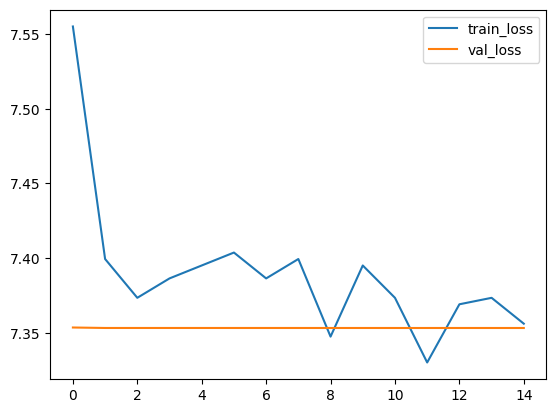

In [26]:
_ = log.plot()

In [74]:
Sim_Test_Fusion_dataset = FusionSurvDataset(Test_tio_dataset, target_test[0], target_test[1], testmode=True)
Sim_Test_Fusion_dataloader = DataLoader(Sim_Test_Fusion_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
surv = model.interpolate(10).predict_surv_df(Sim_Test_Fusion_dataloader)
ev = EvalSurv(surv, target_test[0], target_test[1], 'km')

/home/anders/.local/lib/python3.10/site-packages/torchio/transforms/transform.py:165: RuntimeWarning: Output shape (128, 128, 241) != target shape (128, 128, 240). Fixing with CropOrPad
  transformed = self.apply_transform(subject)


In [75]:
ev.concordance_td()

0.4858757062146893

In [76]:
time_grid = np.linspace(0, target_test[0].max())
ev.integrated_brier_score(time_grid)

0.3351162764937678

In [85]:
# Moving on to the Shap portion. First attempt will be with the SHAP-package. 
batch = next(iter(Sim_Test_Fusion_dataloader))


/home/anders/.local/lib/python3.10/site-packages/torchio/transforms/transform.py:165: RuntimeWarning: Output shape (128, 128, 241) != target shape (128, 128, 240). Fixing with CropOrPad
  transformed = self.apply_transform(subject)


TypeError: asarray() takes 1 positional argument but 2 were given

In [93]:
background_tuple = [batch[0][:12,:,:,:,:], batch[1][:12,:]]
test_tuple = [batch[0][12:16,:,:,:,:], batch[1][12:16,:]]




In [94]:
explainer = shap.DeepExplainer(net, background_tuple)

shap_values = explainer.shap_values(test_tuple)


/home/anders/.local/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f'unrecognized nn.Module: {module_type}')
